## Ant metadata template
Extracts metadata like body measurements from a ```.mymridon``` experiment file and saves it as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio. Script also shows how to link a ```tag_id``` (the "baracode") to the unique ```ant_id``` (internally attributed identifier for each ant) for a given period.  
How ant metadata is stored is documented in the [py-myrmidon documentation](https://formicidae-tracker.github.io/myrmidon/latest/api/index.html).

In [1]:
import py_fort_myrmidon as fm
from datetime import datetime  # For convenient handling of time and date
import numpy as np  # Basic math library
import pandas as pd  # Used to create a dataframe, similar to the structure used in R

In [2]:
f_myrmidon = "/home/user/Documents/experiment_folder/exp.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
t_start = fm.Time(datetime(2021, 2, 18, 0, 1))  # <year, month, day, hour, minute>
t_end = fm.Time(datetime(2021, 2, 18, 1, 0))

Add a ```tag_id``` column to the dataframe. The ```enumerate``` statement is only used to limit the number of lines printed. Note that the count is a histogram list with the first element as the total count and detection gap counts for subsequent ones. This count is a total and not the detection count within in the period defined by ```t_start``` and ```t_end```.

In [3]:
df_metadata = pd.DataFrame(index=exp.Ants)
df_metadata["tag_id"] = np.nan
identifications = exp.IdentificationsAt(t_start)
identifications_end = exp.IdentificationsAt(t_end)
for ant_id in identifications:
    if identifications[ant_id] != identifications_end[ant_id]:
        print("warning: tag_id is not unqiue over the whole period for ant {}".format(ant_id))
    df_metadata.loc[ant_id, "tag_id"] = fm.FormatAntID(identifications[ant_id])

Extract basic ant metadata.

In [4]:
print(exp.MeasurementTypeNames)  # Returns a dictionary with {integer_id: name} of a body measurement 
print(exp.HEAD_TAIL_MEASUREMENT_TYPE_ID)  # Returns the integer_id of the mandatory head-tail measurement

df_metadata["head_tail_px"] = np.nan
for ant in exp.Ants:
    head_tail_pixels = fm.Query.ComputeMeasurementFor(experiment=exp,
                                                      antID=ant,
                                                      measurementTypeID=exp.HEAD_TAIL_MEASUREMENT_TYPE_ID)
    df_metadata.loc[ant, "head_tail_px"] = head_tail_pixels[0].LengthPixel

{1: 'head-tail'}
1


Extract the number of detections in period (```t_start```, ```t_end```). Note that the counts listen in a query result from ```fm.Query.staticComputeTagStatistics``` are tag, i.e. "barcode" counts, from which it is not directly possible to find the counts of an ant during a given period. Instead we query and summarize trajectories.

In [5]:
df_metadata["counts"] = 0
trajectories = fm.Query.ComputeAntTrajectories(experiment=exp, start=t_start, end=t_end)
for t in trajectories:
    df_metadata.loc[t.Ant, "counts"] += len(t.Positions)

Save dataframe and optionally plot.

In [6]:
f_name = "ant_metadata_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
df_metadata.to_csv(f_name, index_label='ant_id')
print(df_metadata[:10].to_markdown())  # Show csv preview

|    |   tag_id |   head_tail_px |   counts |
|---:|---------:|---------------:|---------:|
|  1 |      001 |        269.268 |        0 |
|  2 |      005 |        277.51  |     3074 |
|  3 |      006 |        297.901 |        0 |
|  4 |      007 |        295.665 |        0 |
|  5 |      010 |        308.11  |    19913 |
|  6 |      011 |        189.188 |        0 |
|  7 |      013 |        284.823 |    28189 |
|  8 |      014 |        324.039 |     7438 |
|  9 |      021 |        294.635 |    25012 |
| 10 |      024 |        317.289 |     6585 |


<AxesSubplot:xlabel='tag_id'>

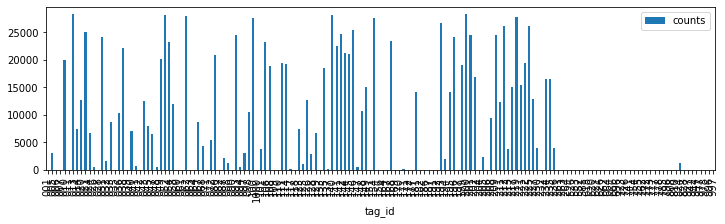

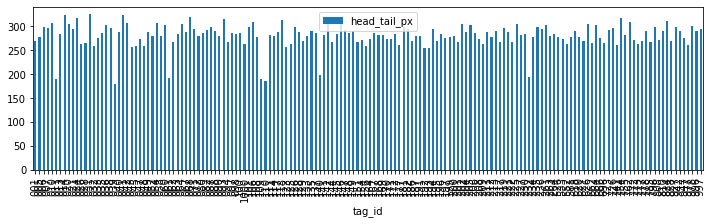

In [7]:
df_metadata.pivot_table(values='counts', index='tag_id').plot(kind='bar', figsize=(12,3))
df_metadata.pivot_table(values='head_tail_px', index='tag_id').plot(kind='bar', figsize=(12,3))